# [TWD] Praca domowa 6

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Wczytanie danych

In [53]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
chess_king_rook_vs_king = fetch_ucirepo(id=23) 
  
# data (as pandas dataframes) 
X = chess_king_rook_vs_king.data.features 
y = chess_king_rook_vs_king.data.targets 

In [54]:
df = pd.concat([X, y], axis=1)
df.head()

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw


## Przygotowanie danych

Mapowanie pozycji podanych za pomoc liter na liczby całkowite

In [55]:
file_map = {c:i+1 for i,c in enumerate("abcdefgh")}

for col in ["white-king-file", "white-rook-file", "black-king-file"]:
    df[col] = df[col].map(file_map)
    
df.head()

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win
0,1,1,2,3,3,2,draw
1,1,1,3,1,3,2,draw
2,1,1,3,1,4,1,draw
3,1,1,3,1,4,2,draw
4,1,1,3,2,3,1,draw


Mapowanie liczby ruchów na liczby całkowite

In [56]:
depth_map = {
    "draw": -1, "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
    "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9,
    "ten": 10, "eleven": 11, "twelve": 12, "thirteen": 13,
    "fourteen": 14, "fifteen": 15, "sixteen": 16
}

df["white-depth-of-win"] = df["white-depth-of-win"].map(depth_map)
df["white-depth-of-win"].unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16])

Przygotowanie kolumn, które opisują odległość pomiędzy białym królem a czarnym królem w trzech metrykach: euklidesowej, Manhattan oraz Czebyszewa

In [57]:
wk_x = df["white-king-file"]
wk_y = df["white-king-rank"]
bk_x = df["black-king-file"]
bk_y = df["black-king-rank"]

df["dist_euclid"] = np.sqrt((wk_x - bk_x)**2 + (wk_y - bk_y)**2)
df["dist_manhattan"] = abs(wk_x - bk_x) + abs(wk_y - bk_y)
df["dist_chebyshev"] = np.maximum(abs(wk_x - bk_x), abs(wk_y - bk_y))

Przygotowanie kolumny, która opisuje odległość czarnego króla od najbliższej krawędzi planszy

In [58]:
df["edge_dist"] = np.minimum.reduce([
    bk_x - 1,
    8 - bk_x,
    bk_y - 1,
    8 - bk_y
])

Przygotowanie ramki danych bez remisów (zadanie 2 i 3)

In [59]:
df_no_draw = df[df["white-depth-of-win"] != -1]

## Wizualizacje

### Zadanie 1

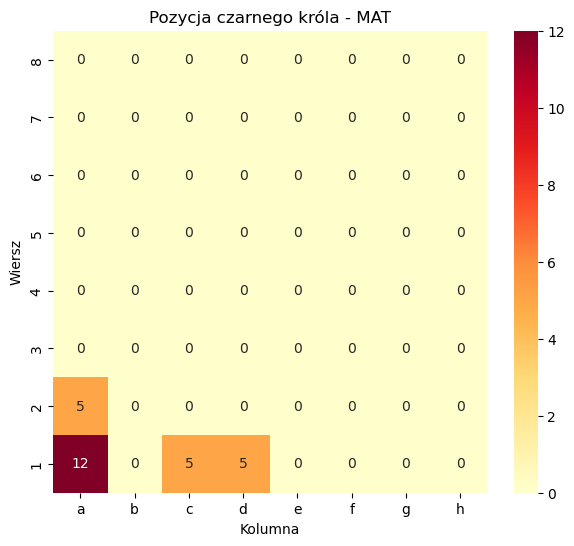

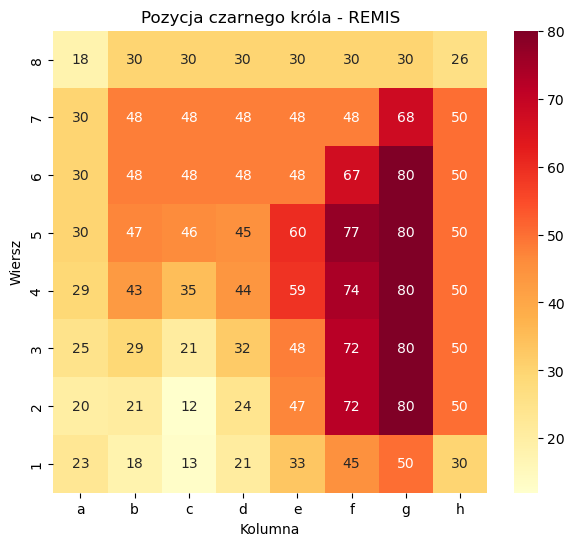

In [60]:
def heatmap_black_king(data, title):
    
    heatmap_data = data.groupby(['black-king-rank', 'black-king-file']).size().unstack(fill_value=0)
    heatmap_data = heatmap_data.reindex(index=range(1, 9), columns=range(1, 9), fill_value=0)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        heatmap_data, 
        annot=True,
        fmt="d",
        cmap="YlOrRd",
        xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
        yticklabels=range(1, 9)
    )
    
    plt.title(title)
    plt.ylabel("Wiersz")
    plt.xlabel("Kolumna")
    plt.gca().invert_yaxis()
    plt.show()
    
heatmap_black_king(df[df["white-depth-of-win"] == 0], "Pozycja czarnego króla - MAT")
heatmap_black_king(df[df["white-depth-of-win"] == -1], "Pozycja czarnego króla - REMIS")


**Komentarz:** 
 - Czarny król, kiedy jest matowany, znajduje się wyłącznie w pobliżu krawędzi szachownicy (najczęściej w rogu),
 - Czarny król, kiedy gra kończy się remisem, znajduje się bliżej środka szachownicy - najczęściej w drugiej kolumnie od jej brzegu (położenia są dużo bardziej rozproszone).

## Zadanie 2

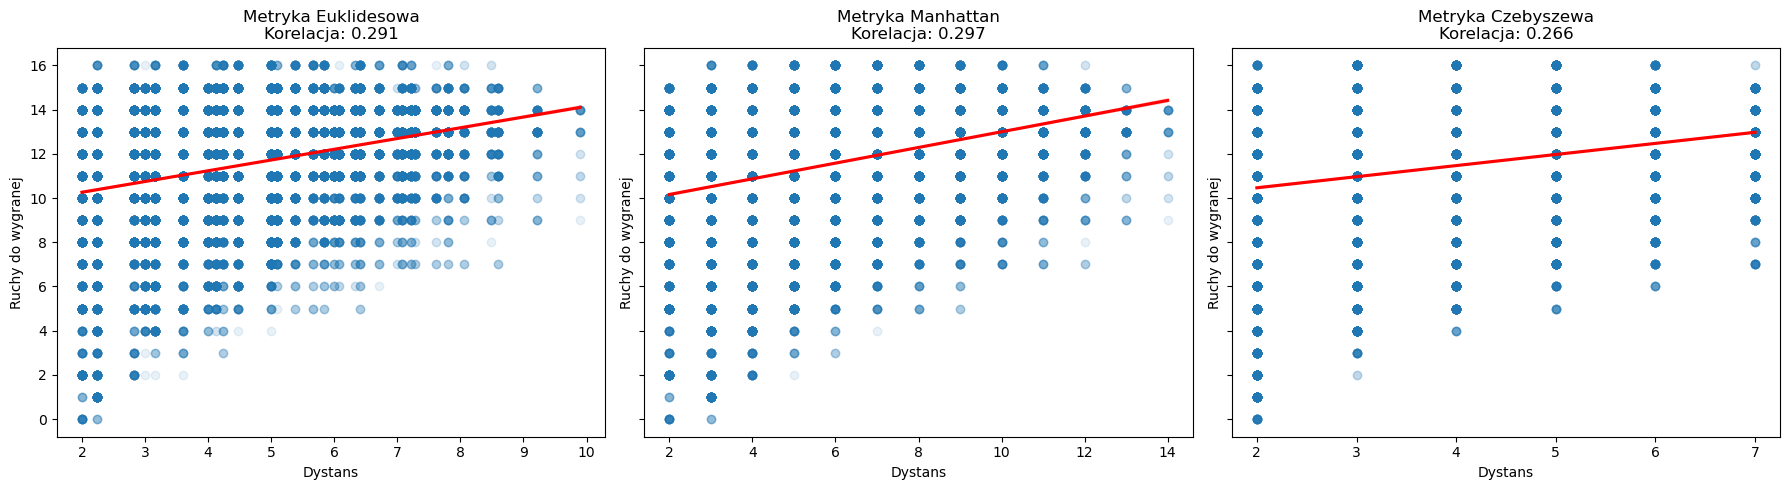

In [61]:
metrics = ['dist_euclid', 'dist_manhattan', 'dist_chebyshev']
titles = ['Metryka Euklidesowa', 'Metryka Manhattan', 'Metryka Czebyszewa']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, metric in enumerate(metrics):
    corr = df_no_draw[metric].corr(df_no_draw['white-depth-of-win'])
    
    sns.regplot(data=df_no_draw, x=metric, y='white-depth-of-win', 
                ax=axes[i], scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
    
    axes[i].set_title(f"{titles[i]}\nKorelacja: {corr:.3f}")
    axes[i].set_xlabel("Dystans")
    axes[i].set_ylabel("Ruchy do wygranej")

plt.tight_layout()
plt.show()

**Komentarz:** Na podstawie analizy współczynnika korelacji można stwierdzić, że najlepiej liczbę ruchów pozwala oszacować **metryka Manhattan**. 

## Zadanie 3

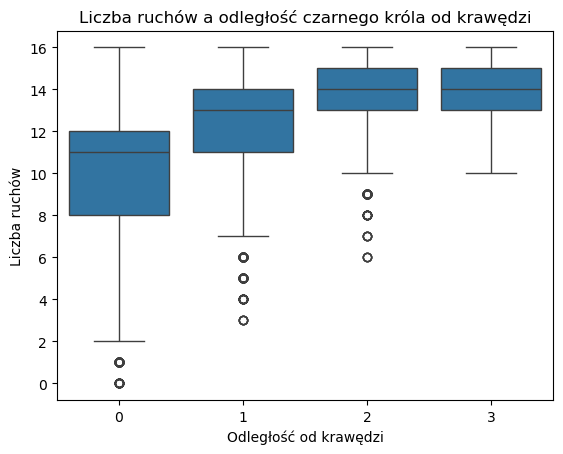

In [62]:
sns.boxplot(data=df_no_draw, x="edge_dist", y="white-depth-of-win")
plt.title("Liczba ruchów a odległość czarnego króla od krawędzi")
plt.ylabel("Liczba ruchów")
plt.xlabel("Odległość od krawędzi")
plt.show()

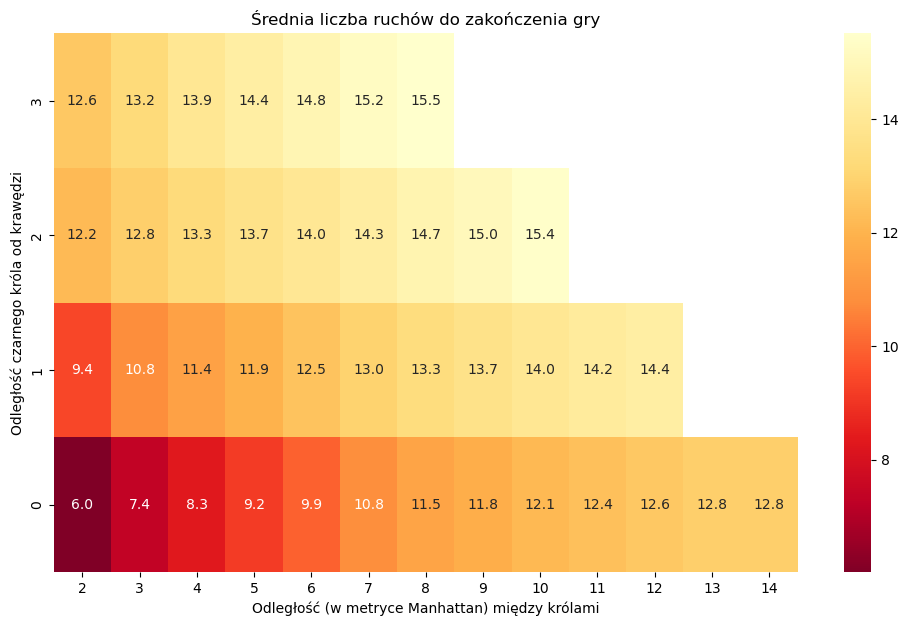

In [65]:
pivot = df_no_draw.groupby(['edge_dist', 'dist_manhattan'])['white-depth-of-win'].mean().unstack()
plt.figure(figsize=(12, 7))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='YlOrRd_r')
plt.title('Średnia liczba ruchów do zakończenia gry')
plt.xlabel('Odległość (w metryce Manhattan) między królami')
plt.ylabel('Odległość czarnego króla od krawędzi')
plt.gca().invert_yaxis()
plt.show()

**Komentarz:** Informacja o odległości czarnego króla od krawędzi planszy jest przydatna w określeniu w ilu ruchach zakończy się gra - im mniejsza odległość od krawędzi, tym mniejsza liczba ruchów jest potrzebna do zakończenia gry. 

Dodatkowe uwzględnienie odległości pomiędzy białym a czarnym królem jeszcze bardziej poprawia możliwość przewidywania liczby ruchów do zakończenia gry. Sama informacja o położeniu czarnego króla względem krawędzi może nie być wystarczająca - nawet jeśli czarny król znajduje się bezpośrednio przy krawędzi, to oddalenie od niego białego króla znacząco wydłuża grę. Dopiero połączenie obu informacji: odległości od krawędzi oraz odległości między królami, pozwala możliwie dokładnie estymować liczbę ruchów do zakończenia gry.